In [1]:
from tvb.simulator.simulator import Simulator
from tvb.datatypes.connectivity import Connectivity
from tvb.contrib.inversion.sbiInference import sbiModel

import tvb.simulator.models
import tvb.simulator.integrators
import tvb.simulator.coupling
import tvb.simulator.monitors

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import arviz as az
import pickle

%load_ext autoreload
%autoreload 2

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [26]:
#run_ids = [
#    "2022-08-02_17-39-15-535669_instance",
#    "2022-08-02_17-39-15-536677_instance",
#    "2022-08-02_17-39-15-560830_instance",
#    "2022-08-02_17-39-15-566932_instance",
#    "2022-08-02_17-39-15-656787_instance",
#    "2022-08-02_17-39-15-662583_instance"
#]

#run_ids = [
#    "2022-08-02_18-11-00-914584_instance",
#    "2022-08-02_18-11-00-915996_instance",
#    "2022-08-02_18-11-00-916394_instance",
#    "2022-08-02_18-11-00-928621_instance",
#    "2022-08-02_18-11-00-960091_instance",
#    "2022-08-02_18-11-00-964377_instance"
#]

#run_ids = [
#    "2022-08-04_14-38-33-259417_instance",
#    "2022-08-04_14-38-33-266844_instance",
#    "2022-08-04_14-38-33-267835_instance",
#    "2022-08-04_14-38-33-268056_instance",
#    "2022-08-04_14-38-33-270680_instance",
#    "2022-08-04_14-38-33-280629_instance"
#]

#run_ids = [
#    "2022-08-05_11-7-09-822425_instance",
#    "2022-08-05_11-7-09-825593_instance",
#    "2022-08-05_11-7-09-829123_instance",
#    "2022-08-05_11-7-09-833147_instance",
#    "2022-08-05_11-7-09-846828_instance",
#    "2022-08-05_11-7-09-857880_instance"
#]

run_ids = [
    "2022-08-05_12-7-35-719303_instance",
    "2022-08-05_12-7-35-723258_instance",
    "2022-08-05_12-7-35-731066_instance",
    "2022-08-05_12-7-35-751849_instance",
    "2022-08-05_12-7-35-765617_instance",
    "2022-08-05_12-7-35-778611_instance"
]

#run_ids = [
#    "2022-08-05_14-24-57-808939_instance",
#    "2022-08-05_14-24-57-819499_instance",
#    "2022-08-05_14-24-57-828211_instance",
#    "2022-08-05_14-24-57-843612_instance",
#    "2022-08-05_14-24-57-850003_instance",
#    "2022-08-05_14-24-57-861756_instance"
#]

In [27]:
with open(f"sbi_data/inference_data/{run_ids[0]}.pkl", "rb") as f:
    instance_params = pickle.load(f)
    simulation_params = instance_params["simulation_params"]

In [28]:
simulation_params

{'connectivity': 'Own',
 'model': 'Generic2dOscillator',
 'integrator': 'HeunStochastic',
 'coupling': 'Difference',
 'monitor': 'Raw',
 'a_sim': 2.0,
 'b_sim': -10.0,
 'c_sim': 0.0,
 'd_sim': 0.02,
 'I_sim': 0.0,
 'nsig': 0.003,
 'dt': 1.0,
 'simulation_length': 1000}

In [29]:
# Connectivity
if simulation_params["connectivity"] == "Own":
    connectivity = Connectivity()
    connectivity.weights = np.array([[0., 2/3], [2/3, 0.]])
    connectivity.region_labels = np.array(["R1", "R2"])
    connectivity.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
    connectivity.tract_lengths = np.array([[0., 0.1], [0.1, 0.]])
    connectivity.configure()

# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.configure()

# Global coupling
coupling = getattr(tvb.simulator.coupling, simulation_params["coupling"])()

# Monitor
monitor = getattr(tvb.simulator.monitors, simulation_params["monitor"])()

In [30]:
# Simulator
sim = Simulator(
    model=oscillator_model,
    connectivity=connectivity,
    coupling=coupling,
    integrator=integrator,
    monitors=(monitor,),
    simulation_length=simulation_params["simulation_length"]
)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 58a2f863-b825-4b4a-a435-09ab68fd2df7
coupling,Difference gid: b63f2791-00f7-454d-8316-acf4d7a2c819
gid,UUID('101146dc-aeca-4c7f-9fcc-dfdfa1a77d1d')
initial_conditions,None
integrator,HeunStochastic gid: d9ec4f0f-ae9c-44e0-9c48-d5bfbe4d803c
model,Generic2dOscillator gid: b243f3b8-0045-4f76-9c95-947dc4906844
monitors,"(,)"
simulation_length,1000.0


In [31]:
X = instance_params["obs"]

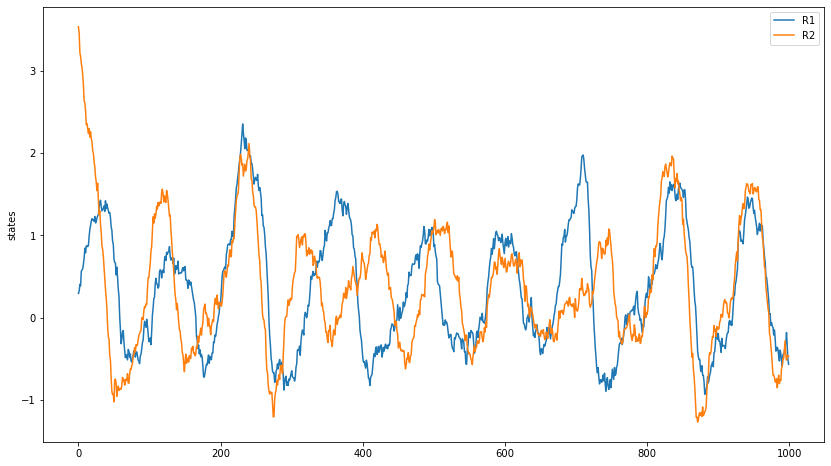

In [32]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="R1")
plt.plot(X[:, 0, 1, 0], label="R2")
plt.ylabel("states")
plt.legend()
plt.show()

### SNPE inference

In [33]:
snpe_model = sbiModel(
    simulator_instance=sim,
    method="SNPE", 
    obs=X
)

In [34]:
criteria = []
for i in run_ids:
    snpe_model.load(f"{i}.pkl")
    criteria.append(snpe_model.information_criteria())

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities 

In [35]:
criteria

[{'WAIC': 6362.988072574035, 'LOO': 4686.623319853075},
 {'WAIC': 7452.395491412018, 'LOO': 4657.325320681228},
 {'WAIC': 7808.821667698294, 'LOO': 5940.254239629217},
 {'WAIC': nan, 'LOO': nan},
 {'WAIC': 6048.750791889117, 'LOO': 5030.182688629127},
 {'WAIC': 6829.963949895533, 'LOO': 4628.34102999107}]

In [38]:
snpe_model.load(f"{run_ids[2]}.pkl")

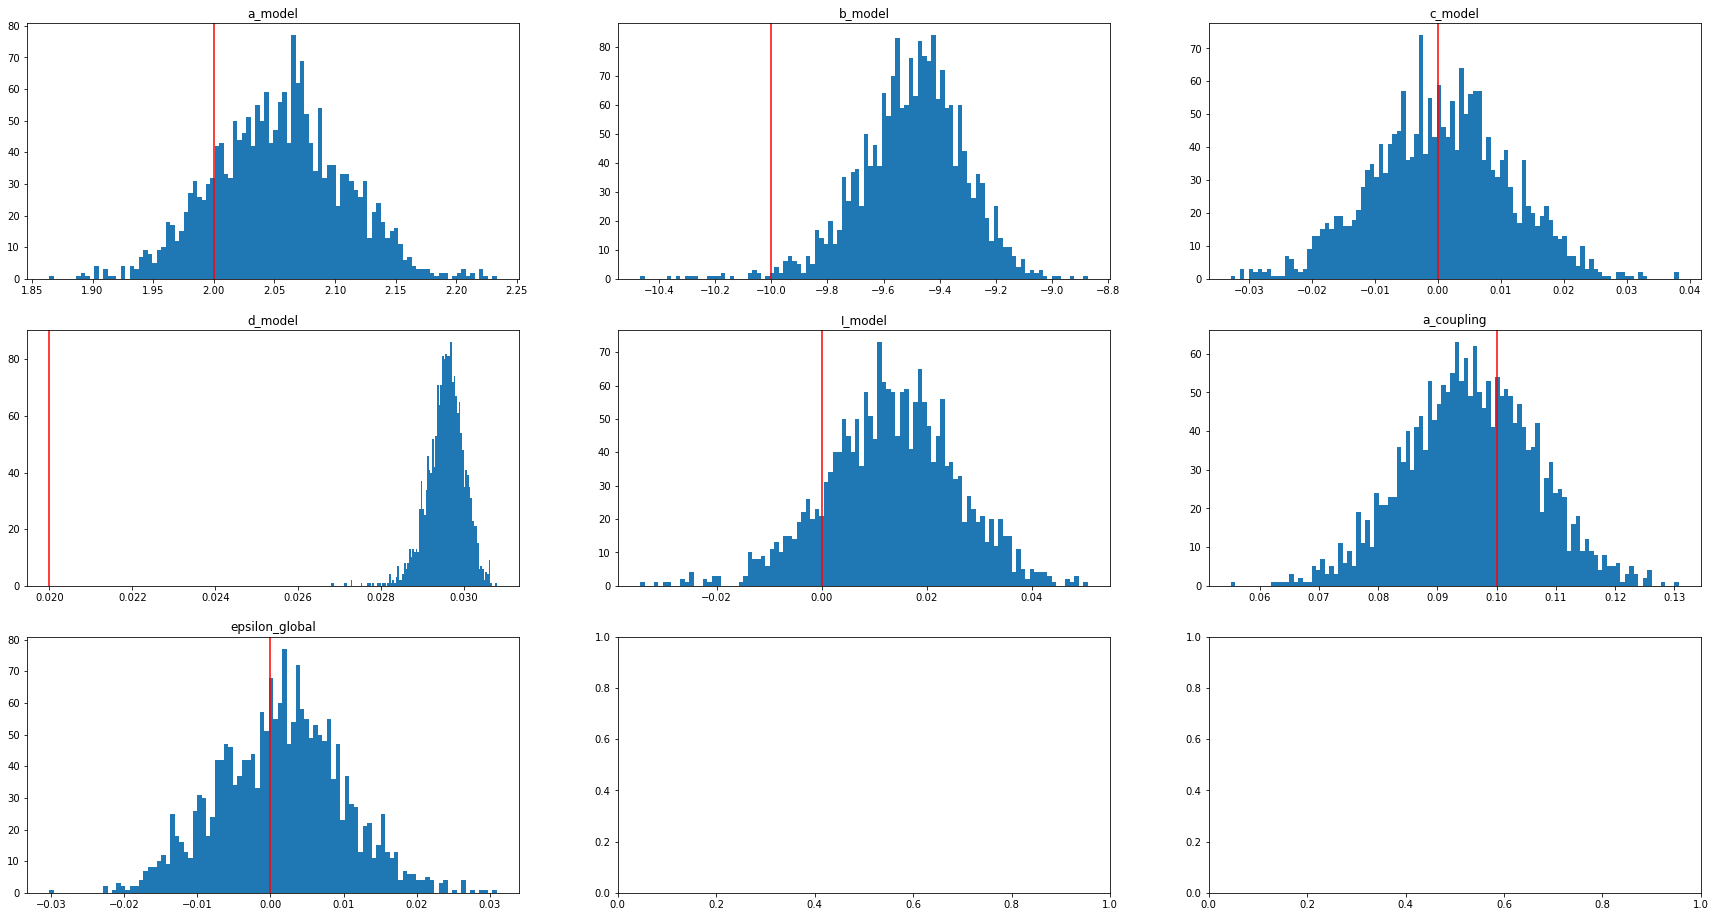

In [39]:
snpe_model.plot_posterior_samples(
    init_params={"a_model": simulation_params["a_sim"], 
                 "b_model": simulation_params["b_sim"],
                 "c_model": simulation_params["c_sim"],
                 "d_model": simulation_params["d_sim"],
                 "I_model": simulation_params["I_sim"],
                 "a_coupling": 0.1, 
                 "epsilon_global": 0.0}
)

In [31]:
posterior_sample = snpe_model.get_sample()[0]
posterior_sample

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/pyknos/mdn/mdn.py:279: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(


tensor([ 2.6099e+00, -9.8630e+00, -4.3226e-02,  2.9889e-02,  2.1834e-01,
         6.0875e-03])

In [33]:
posterior_obs = snpe_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(X.shape, order="F")

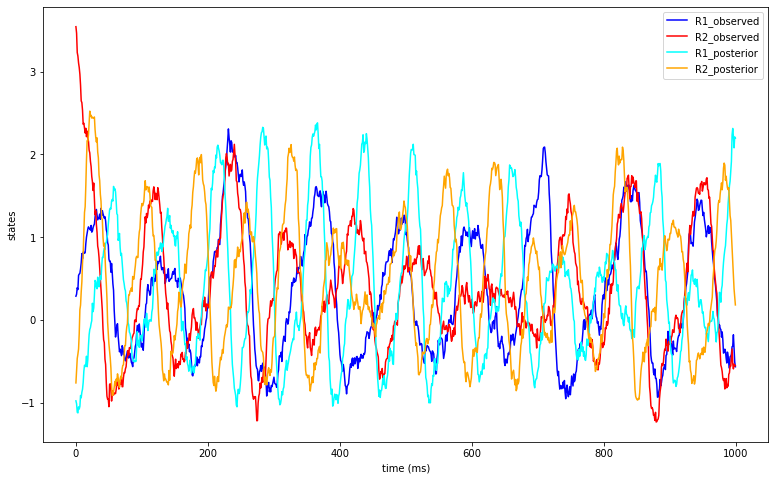

In [34]:
f3 = plt.figure(figsize=(13,8))
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="R1_observed", color="blue")
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 1, 0], label="R2_observed", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="R1_posterior", color="cyan")
plt.plot(posterior_obs[:, 0, 1, 0], label="R2_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snpe_model.information_criteria()

In [ ]:
#snpe_model.save()

### SNLE inference

In [ ]:
snle_model = sbiModel(
    simulator_instance=sim,
    method="SNLE", 
    obs=obs, 
    prior_vars=priors,
    prior_dist="Normal",
)

In [ ]:
snle_model.run_inference(
    num_simulations=800,
    num_workers=4,
    num_samples=2000
)

In [ ]:
inference_data = snle_model.to_arviz_data(save=True)

In [ ]:
snle_model.plot_posterior_samples(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0},
    bins=50
)

In [ ]:
map_estimator = snle_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snle_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snle_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snle_model.information_criteria()

### SNRE inference

In [ ]:
snre_model = sbiModel(
    integrator_instance=integrator, 
    model_instance=oscillator_model, 
    method="SNRE", 
    obs=obs, 
    priors=priors,
    obs_shape=shape
)

In [ ]:
snre_model.run_inference(
    num_simulations=800,
    num_workers=1,
    num_samples=2000
)

In [ ]:
inference_data = snre_model.to_arviz_data(save=True)

In [ ]:
snre_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0}
)

In [ ]:
map_estimator = snre_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snre_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snre_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snre_model.information_criteria()